# `Pysal` and Kepler.gl

In [1]:
from IPython.display import IFrame
from keplergl import KeplerGl
import pandas as pd
import geopandas as gpd
from json import dump, load

from pysal.lib.cg import alpha_shape_auto
from pysal.lib.weights import Queen
from pysal.explore.esda import Moran_Local

/opt/conda/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## NYC Projects under construction

- [[`URL`](https://data.cityofnewyork.us/Housing-Development/Projects-in-Construction-Map/dzgh-ja44)]

In [2]:
%%time
url = 'https://data.cityofnewyork.us/api/views/dzgh-ja44/rows.csv?accessType=DOWNLOAD'
pts = pd.read_csv(url)

CPU times: user 40 ms, sys: 10 ms, total: 50 ms
Wall time: 1.28 s


In [3]:
pts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 20 columns):
School Name              2831 non-null object
BoroughCode              2834 non-null object
Geographical District    2834 non-null int64
Project Description      2831 non-null object
Construction Award       2834 non-null float64
Project type             2834 non-null object
Building ID              2834 non-null object
Building Address         2834 non-null object
City                     2834 non-null object
Postcode                 2828 non-null float64
Borough                  2826 non-null object
Location 1               2824 non-null object
Latitude                 2824 non-null float64
Longitude                2824 non-null float64
Community Board          2824 non-null float64
Council District         2824 non-null float64
Census Tract             2824 non-null float64
BIN                      2810 non-null float64
BBL                      2810 non-null float64
NTA        

### Points

In [4]:
m1 = KeplerGl()
m1.add_data(data=pts, name='Projects')
m1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'Projects': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…

### Polygons

Now what if we want to draw the extent of a borough through the currently ongoing projects? For this we can turn groups of points into polygons using [`PySAL`'s alpha shapes](https://github.com/pysal/pysal/blob/master/pysal/lib/cg/alpha_shapes.py). 

Just for fun, let's first generate the boundary of NYC through its current projects:

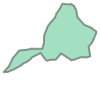

In [5]:
poly = alpha_shape_auto(pts[['Longitude', 'Latitude']].dropna().values)
poly

Let's turn it into a `GeoDataFrame`:

In [6]:
nyc = gpd.GeoDataFrame({'geometry': [poly]}, crs='+init=epsg:4326')

Now we can take this philosophy and apply it to each borough:

In [7]:
boros = pts.groupby('BoroughCode')\
           [['Longitude', 'Latitude']]\
           .apply(lambda tab: alpha_shape_auto(tab.dropna().values))
boros = gpd.GeoDataFrame({'geometry': boros}, crs='+init=epsg:4326')

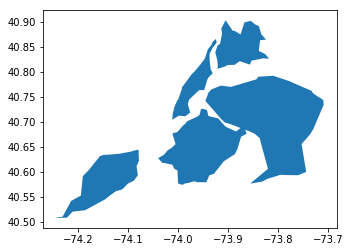

In [8]:
boros.plot()

Now let's ship this over to Kepler!

In [9]:
m2 = KeplerGl()
m2.add_data(data=boros, name='Boroughs')
m2.add_data(data=nyc, name='NYC')
m2

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'Boroughs': {'index': ['K', 'M', 'Q', 'R', 'X'], 'columns': ['geometry'], 'data': [['POLYGON ((…

After a bit of (manual) tweaking, we can style it up and save the config:

In [10]:
# Commented out to avoid re-write when not tweaked
#with open('config.json', 'w') as f:
#    dump(m2.config, f)

And we can now load it back up!

In [11]:
config = load(open('config.json'))
m2_re = KeplerGl(data={'Boroughs': boros,
                       'NYC': nyc},
                 config=config)
m2_re

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'lg9tj1', 'type': '…

## Attractive Neighborhoods in Madrid

Using data from [Arturo](http://300000kms.net/on-going-arturo-an-algorithm-for-more-livable-cities/) and, based on [this tutorial](https://github.com/darribas/gds_ucm19/blob/master/pack/notebooks/02_explore.ipynb), we can calculate hotspots and coldspots of attractiveness in Madrid.

In [12]:
url = ("https://github.com/darribas/gds_ucm19/blob/master/"\
       "pack/data/demo_data.gpkg?raw=true")
mad = gpd.read_file(url)

In [13]:
m3 = KeplerGl()
m3.add_data(data=mad, name='Madrid')
m3

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'Madrid': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

Now, let's calculate [Local Indicators of Spatial Association](http://darribas.org/gds18/content/labs/lab_06.html#Local-Spatial-autocorrelation) for the `arturo_score`, which measures the degree of attractiveness of a neighbourhood:

In [14]:
w = Queen.from_dataframe(mad)
lisa = Moran_Local(mad['arturo_score'], w)

To find out the clusters, we want to plot significant clusters identified at say, 1% significance level. Let's first create a column for that:

In [15]:
sig = lisa.p_sim < 0.01
mad['clusters'] = lisa.q * sig

Now let's make those human-readable by translating the number code to the type of cluster:

In [16]:
cross_walk = {1: 'High-High', 2: 'Low-High', 
              3: 'Low-Low', 4: 'High-Low',
              0: 'Non-Sig. (1%)'}
mad['lisa_labels'] = mad['clusters'].map(cross_walk)

And we can ship this to Kepler now! Note how we work a bit more on parsing the results and a pre-defined `config` so the default looks like a proper [LISA cluster map](https://geodacenter.github.io/workbook/6a_local_auto/lab6a.html):

In [17]:
hh = mad.query('lisa_labels == "High-High"')
ll = mad.query('lisa_labels == "Low-Low"')
lh = mad.query('lisa_labels == "Low-High"')
hl = mad.query('lisa_labels == "High-Low"')
ns = mad.query('lisa_labels == "Non-Sig. (1%)"')

In [18]:
m4 = KeplerGl(height=600, 
              data={'High-High': hh,
                    'Low-Low': ll,
                    'Low-High': lh,
                    'High-Low': hl,
                    'Non-Sig. (1%)': ns},
              config=load(open('config_lisa.json')))
m4

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'rw8f0te', 'type': …

In [19]:
with open('config_lisa.json', 'w') as f:
    dump(m4.config, f)